In [1]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt 

from dekef.base_density import *

from IFlogdensity.contam_ml_de import *

from IPython.display import Markdown as md

from datetime import datetime as dt

In [2]:
os.chdir('/Users/chenxizhou/Dropbox/code_package/IFlogdensity')

true_data = np.load('data/geyser.npy').astype(np.float64)
df = copy.deepcopy(true_data[:, 0]).reshape(-1, 1)
data_waiting = df[df != 108.0]

xlimit = (1., 310.)
plot_pts_cnt = 3000
new_data = np.linspace(xlimit[0], xlimit[1], plot_pts_cnt)

contam_weight = 1e-3

kernel_type = 'gaussian_poly2'
bw = 9.0
log_pen_param = -10.

var_name = 'additional observation'
method = 'ML'

base_density = BasedenGamma(data_waiting)
seed_no = 1

contam_pt_list = [20., 120., 150., 200.]

### Uncontaminated Density 

In [3]:
uncontam_ml = ContamMLDensityEstimate(
    data = data_waiting, 
    contam_data = np.array([contam_pt_list[0]]).reshape(-1, 1), 
    contam_weight = 0., 
    penalty_param = np.exp(log_pen_param), 
    base_density = base_density,
    r1 = 1.0, 
    r2 = 0.0, 
    c = 0., 
    bw = bw, 
    kernel_type = 'gaussian_poly2')

In [4]:
start_grid_points = np.arange(1., 311., 1)
gdalgo_params = negloglik_optalgoparams(
        start_pt=np.zeros((start_grid_points.shape[0], 1)),
        step_size=0.3,
        max_iter=50,
        rel_tol=1e-5,
        abs_tol=0.05)

bmc_params = batch_montecarlo_params(
        mc_batch_size=5000,
        mc_tol=5e-3)

In [5]:
np.random.seed(seed_no)
print(f'start time = {dt.now().strftime("%H:%M:%S")}')
uncontam_coef = uncontam_ml.coef_grid_points(
    optalgo_params = gdalgo_params, 
    batchmc_params = bmc_params, 
    algo = 'gd', 
    step_size_factor = 1., 
    grid_points = start_grid_points, 
    print_error = True)
print(f'end time = {dt.now().strftime("%H:%M:%S")}')

start time = 17:18:04
Iter = 1, GradNorm = 0.6351339312414779, Relative Error = 0.9999999842552895
Iter = 2, GradNorm = 0.3490174256750211, Relative Error = 0.5495178308260567
Iter = 3, GradNorm = 0.28243496830058334, Relative Error = 0.4446856796040783
Iter = 4, GradNorm = 0.2410420885192017, Relative Error = 0.37951378893095167
Iter = 5, GradNorm = 0.20039764792261325, Relative Error = 0.31552029408301147
Iter = 6, GradNorm = 0.16796920846624522, Relative Error = 0.2644626551336883
Iter = 7, GradNorm = 0.14381081087884315, Relative Error = 0.22642595764562717
Iter = 8, GradNorm = 0.1439079715744602, Relative Error = 0.22657893434756055
Iter = 9, GradNorm = 0.13807945347715056, Relative Error = 0.21740210136975305
Iter = 10, GradNorm = 0.1034297442733743, Relative Error = 0.16284713752063568
Iter = 11, GradNorm = 0.11270527991602931, Relative Error = 0.17745119981421173
Iter = 12, GradNorm = 0.08256666972970517, Relative Error = 0.129998830747912
Iter = 13, GradNorm = 0.08601465814654

In [6]:
kernel_function_grid = GaussianPoly2(
    data=start_grid_points.reshape(-1, 1),
    r1=uncontam_ml.r1,
    r2=uncontam_ml.r2,
    c=uncontam_ml.c,
    bw=uncontam_ml.bw)

gram_grid = kernel_function_grid.kernel_gram_matrix(start_grid_points.reshape(-1, 1))

uncontam_norm = np.sqrt(uncontam_coef[0].T @ gram_grid @ uncontam_coef[0]).item()

uncontam_norm

2.3277088944243087

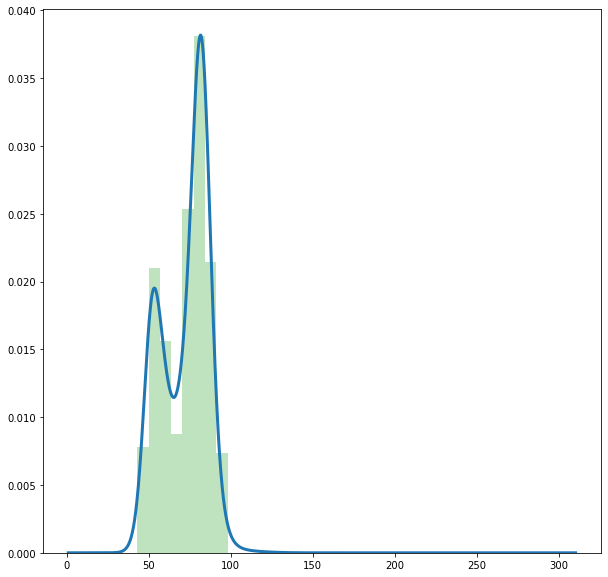

In [7]:
uncontam_logden_vals = uncontam_ml.log_density(new_data, uncontam_coef, True)

plt.figure(figsize = (10, 10))
plt.plot(new_data, np.exp(uncontam_logden_vals), color = 'tab:blue', lw = 3.0)
plt.hist(data_waiting, bins='fd', density = True, alpha = 0.3, color = 'tab:green')
# plt.axvline(x = 20., color = 'k', linestyle='--')
plt.show()

In [ ]:
# for contam_pt in contam_pt_list: 
#     full_save_folder = (f'data/PenML-GD-ContamData={contam_pt}-basisn={len(start_grid_points)}-bw={bw}-kernel={kernel_type}-' + 
#                         f'contamweight={contam_weight}-plotdomain={xlimit}-plotcnts={plot_pts_cnt}-' + 
#                         f'seed={seed_no}-new')
#     if not os.path.isdir(full_save_folder):
#         os.mkdir(full_save_folder)

#     file_name_newdata = f'/new_data.npy'
#     np.save(full_save_folder + file_name_newdata, new_data)

#     file_name_grid_points = f'/grid_points.npy'
#     np.save(full_save_folder + file_name_grid_points, start_grid_points)

#     file_name_coef = f'/logpenparam={log_pen_param}-uncontam-coef.npy'
#     np.save(full_save_folder + file_name_coef, uncontam_coef[0])

#     file_name_diff = f'/logpenparam={log_pen_param}-uncontam-logden-newdata.npy'
#     np.save(full_save_folder + file_name_diff, uncontam_logden_vals)

### Contaminated Density 

start time = 17:24:43
Iter = 1, GradNorm = 0.6348408267844141, Relative Error = 0.9999999842480202
Iter = 2, GradNorm = 0.3483728101865437, Relative Error = 0.5487561448490242
Iter = 3, GradNorm = 0.28176757301067773, Relative Error = 0.44383971018292145
Iter = 4, GradNorm = 0.24015437652327373, Relative Error = 0.37829068737874505
Iter = 5, GradNorm = 0.19952557804342647, Relative Error = 0.314292286321813
Iter = 6, GradNorm = 0.16696569008444928, Relative Error = 0.2630040167708197
Iter = 7, GradNorm = 0.1428667381382634, Relative Error = 0.22504339648644808
Iter = 8, GradNorm = 0.14302936690511042, Relative Error = 0.22529956899052134
Iter = 9, GradNorm = 0.13675631758913537, Relative Error = 0.21541827441635816
Iter = 10, GradNorm = 0.10204046716731434, Relative Error = 0.16073393716158543
Iter = 11, GradNorm = 0.11120161574593167, Relative Error = 0.17516455984335907
Iter = 12, GradNorm = 0.08173526099244219, Relative Error = 0.1287492175305646
Iter = 13, GradNorm = 0.085692860428

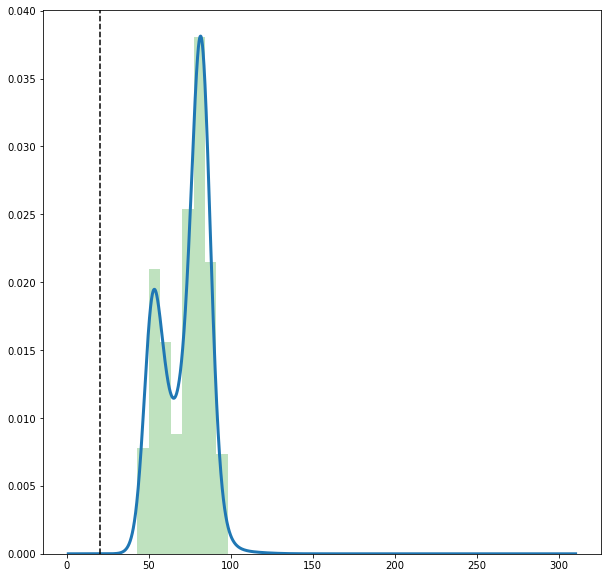

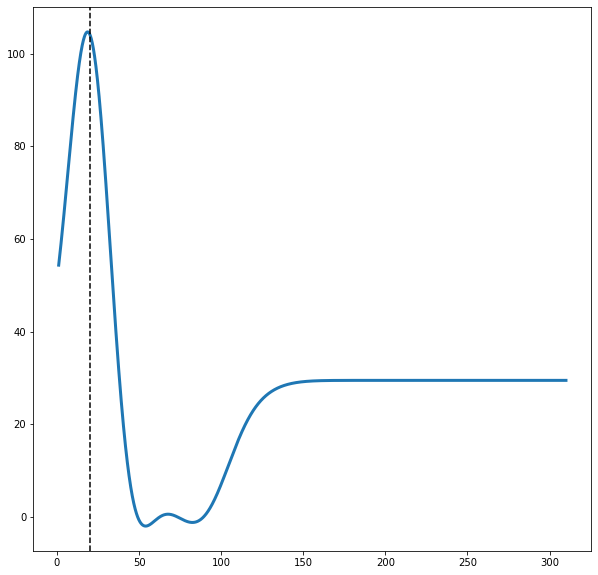

2.3277088944243087 2.306289294626077 104.69347474066026
start time = 17:31:30
Iter = 1, GradNorm = 0.6342997310673972, Relative Error = 0.9999999842345828
Iter = 2, GradNorm = 0.34754161821760643, Relative Error = 0.547913857938464
Iter = 3, GradNorm = 0.28114864062298356, Relative Error = 0.44324255934562995
Iter = 4, GradNorm = 0.23974149275939263, Relative Error = 0.37796246354437496
Iter = 5, GradNorm = 0.1991983455646516, Relative Error = 0.31404450083716157
Iter = 6, GradNorm = 0.16680124362218982, Relative Error = 0.2629691182618131
Iter = 7, GradNorm = 0.14274644966320327, Relative Error = 0.22504573220066285
Iter = 8, GradNorm = 0.14283829908462004, Relative Error = 0.22519053664479236
Iter = 9, GradNorm = 0.13673778414454776, Relative Error = 0.21557282037423808
Iter = 10, GradNorm = 0.10194566243594597, Relative Error = 0.16072158923538607
Iter = 11, GradNorm = 0.11122727697702456, Relative Error = 0.17535444171844008
Iter = 12, GradNorm = 0.08166229010984245, Relative Error

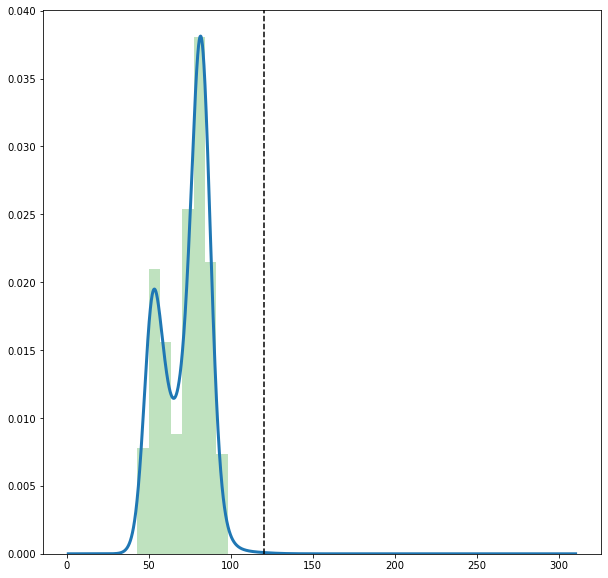

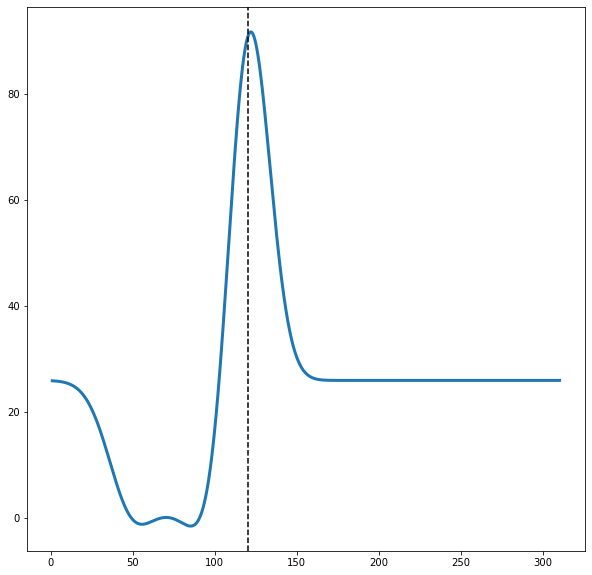

2.3277088944243087 2.2859142710328793 91.68100363208254
start time = 17:38:13
Iter = 1, GradNorm = 0.6347940235352778, Relative Error = 0.9999999842468588
Iter = 2, GradNorm = 0.3483879559566169, Relative Error = 0.54882046388556
Iter = 3, GradNorm = 0.28189738116040264, Relative Error = 0.4440769230146467
Iter = 4, GradNorm = 0.24038472083463974, Relative Error = 0.37868144332720904
Iter = 5, GradNorm = 0.19978082009512232, Relative Error = 0.31471754544148495
Iter = 6, GradNorm = 0.16735823408721656, Relative Error = 0.26364178811695754
Iter = 7, GradNorm = 0.14332799346368455, Relative Error = 0.22578661091923966
Iter = 8, GradNorm = 0.14334415997501115, Relative Error = 0.2258120782526936
Iter = 9, GradNorm = 0.13709634339250565, Relative Error = 0.21596980461361992
Iter = 10, GradNorm = 0.10239253442774458, Relative Error = 0.1613004045698143
Iter = 11, GradNorm = 0.11149039647002491, Relative Error = 0.1756323950449181
Iter = 12, GradNorm = 0.08228028636917989, Relative Error = 0

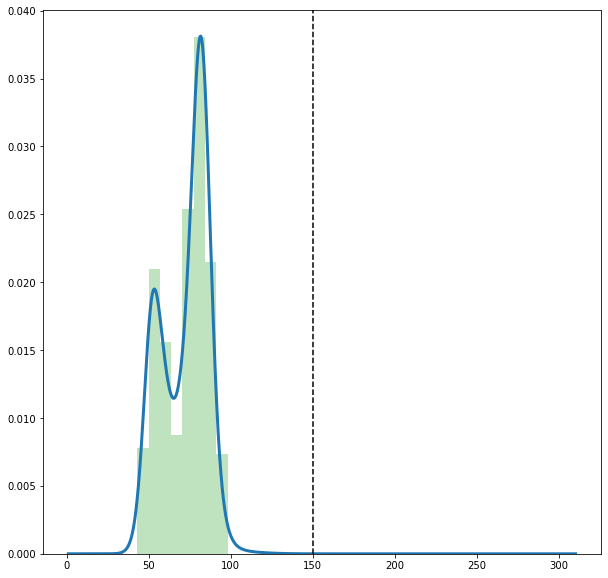

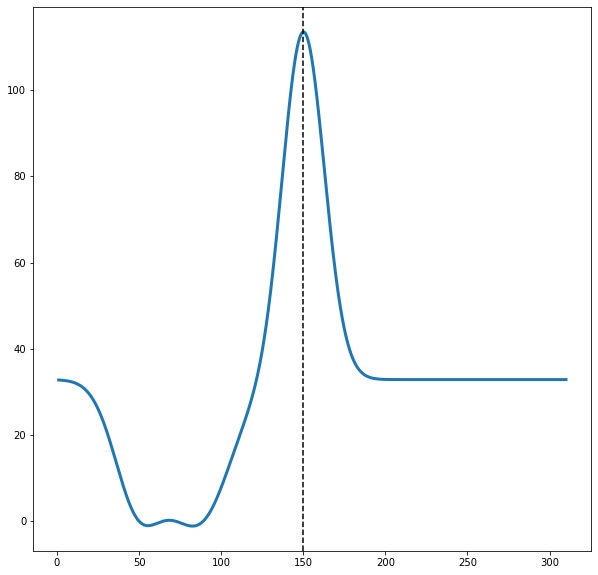

2.3277088944243087 2.3114649339480735 113.51071703270854
start time = 17:45:00
Iter = 1, GradNorm = 0.6348112727716636, Relative Error = 0.9999999842472869
Iter = 2, GradNorm = 0.34841494641778237, Relative Error = 0.548848068510314
Iter = 3, GradNorm = 0.2819264305209303, Relative Error = 0.44411061707978006
Iter = 4, GradNorm = 0.24041220500741337, Relative Error = 0.3787144487378112
Iter = 5, GradNorm = 0.19980113818825904, Relative Error = 0.3147410003740054
Iter = 6, GradNorm = 0.16738910278950367, Relative Error = 0.2636832509634397
Iter = 7, GradNorm = 0.14334767078371882, Relative Error = 0.22581147291183196
Iter = 8, GradNorm = 0.14336197520273197, Relative Error = 0.22583400625268674
Iter = 9, GradNorm = 0.13711284366682847, Relative Error = 0.2159899286417485
Iter = 10, GradNorm = 0.10242279950657757, Relative Error = 0.16134369738891077
Iter = 11, GradNorm = 0.1114926391622799, Relative Error = 0.17563115557034434
Iter = 12, GradNorm = 0.08231788870476382, Relative Error = 

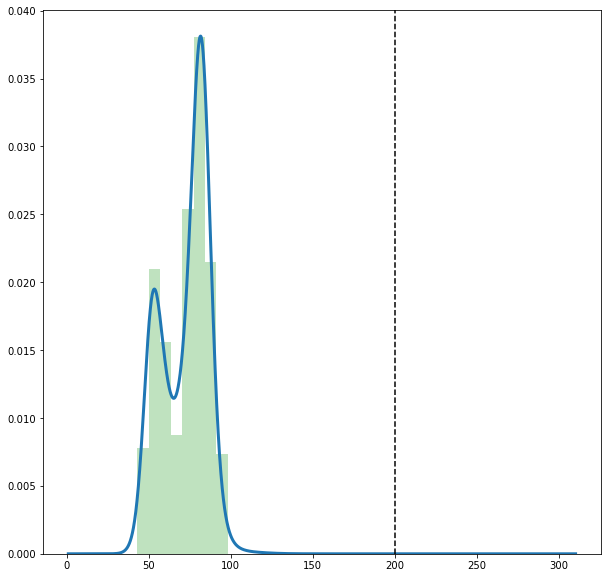

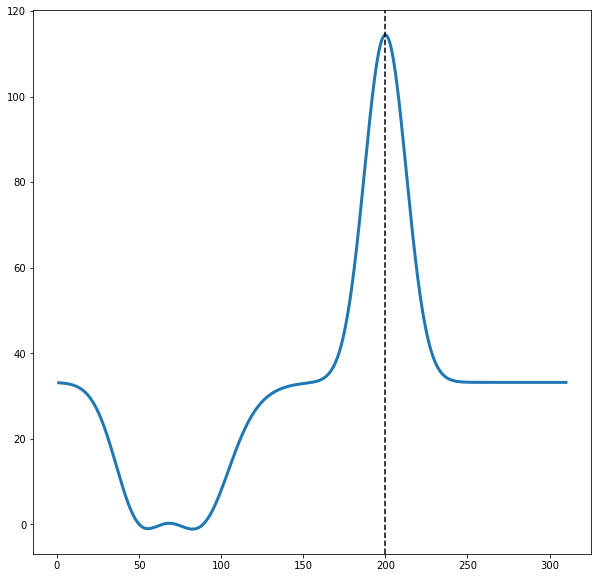

2.3277088944243087 2.313845510358142 114.40088938554638


In [8]:
for contam_pt in contam_pt_list: 
    contam_ml = ContamMLDensityEstimate(
        data = data_waiting, 
        contam_data = np.array(contam_pt).reshape(-1, 1), 
        contam_weight = contam_weight, 
        penalty_param = np.exp(log_pen_param), 
        base_density = base_density,
        r1 = 1.0, 
        r2 = 0.0, 
        c = 0., 
        bw = bw, 
        kernel_type = 'gaussian_poly2')
    
    np.random.seed(seed_no)
    print(f'start time = {dt.now().strftime("%H:%M:%S")}')
    contam_coef = contam_ml.coef_grid_points(
        optalgo_params = gdalgo_params, 
        batchmc_params = bmc_params, 
        algo = 'gd', 
        step_size_factor = 1.0, 
        grid_points = start_grid_points, 
        print_error = True)
    print(f'end time = {dt.now().strftime("%H:%M:%S")}')
    
    contam_norm = np.sqrt(contam_coef[0].T @ gram_grid @ contam_coef[0]).item()
    
    contam_logden_vals = contam_ml.log_density(new_data, contam_coef, True)

    plt.figure(figsize = (10, 10))
    plt.plot(new_data, np.exp(contam_logden_vals), color = 'tab:blue', lw = 3.0)
    plt.hist(data_waiting, bins='fd', density = True, alpha = 0.3, color = 'tab:green')
    plt.axvline(x = contam_pt, color = 'k', linestyle='--')
    plt.show()
    
    IF_vals = (contam_logden_vals - uncontam_logden_vals) / contam_weight

    plt.figure(figsize = (10, 10))
    plt.plot(new_data, IF_vals, color = 'tab:blue', lw = 3.0)
    plt.axvline(x = contam_pt, color = 'k', linestyle='--')
    plt.show()
    
#     full_save_folder = (f'data/PenML-GD-ContamData={contam_pt}-basisn={len(start_grid_points)}-bw={bw}-kernel={kernel_type}-' + 
#                         f'contamweight={contam_weight}-plotdomain={xlimit}-plotcnts={plot_pts_cnt}-' + 
#                         f'seed={seed_no}-new')
    
#     # save coefficients 
#     file_name_coef = f'/logpenparam={log_pen_param}-contam-coef.npy'
#     np.save(full_save_folder + file_name_coef, contam_coef[0])

#     file_name_diff = f'/logpenparam={log_pen_param}-contam-logden-newdata.npy'
#     np.save(full_save_folder + file_name_diff, contam_logden_vals)

#     file_name_ifvals = f'/logpenparam={log_pen_param}-IF-newdata.npy'
#     np.save(full_save_folder + file_name_ifvals, IF_vals)
    
    print(uncontam_norm, contam_norm, np.max(np.abs(IF_vals)))